In [1]:
import cv2
import numpy as np
import os
# from matplotlib import pyplot as plt
import time
import mediapipe as mp


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities



In [3]:

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results



In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 



In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return pose



In [15]:
import cv2

# Open the default webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Failed to open webcam")
    exit()

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Check if frame is successfully read
    if not ret:
        print("Failed to read frame from webcam")
        break

    # Display the frame in a window named "Webcam"
    cv2.imshow('Webcam', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


In [8]:
DATA_PATH = os.path.join('yoga')

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "yoga"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =['bhuj', 'tad', 'shav', 'vrik', 'virbhadra']

In [9]:
print(os.listdir("yoga"))

['bhuj', 'shav', 'tad', 'virbhadra', 'vrik']


In [10]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :]  # Take the last timestep's output
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [15]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Declare a list to store video frames.
        points_list = []
        
        # Read the Video File using the VideoCapture object.
        video_reader = cv2.VideoCapture(video_path)

        # Get the total number of frames in the video.
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        #print(video_frames_count)
        # Calculate the the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

            # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

                # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            #print(frame_counter * skip_frames_window)
                # Reading the frame from the video. 
            success, frame = video_reader.read()
            #print(success)


                # Check if Video frame is not successfully read then break the loop
            if not success:
                 break

            image ,result = mediapipe_detection(frame ,holistic)
            points =  extract_keypoints(result)
            #print(points)
            
            points_list.append(points)
        # Release the VideoCapture object. 
        video_reader.release()
 
    # Return the frames list.
    return np.asarray(points_list)






In [16]:
x =frames_extraction('yoga/virbhadra/357551499_9427674887307361_3491618938100281147_n.mp4')

In [17]:
x.shape

(20, 132)

In [18]:
def create_dataset(output_path):
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            print(f'file name: {file_name}')
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) >= SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
             
    features = np.asarray(features)
    labels = np.array(labels)  
    dataset = {
        'features': features,
        'labels': labels,
        'video_files_paths': video_files_paths
    }
    
    torch.save(dataset, output_path)
   
    
    return

In [19]:
create_dataset('dataset.pth')

Extracting Data of Class: bhuj
file name: 357529539_6536337716427705_3163787805514917899_n.mp4
file name: 357537724_5868960293209628_2722855666547619019_n.mp4
file name: 357547956_6385104144944543_6779183359740109202_n.mp4
file name: 357632533_6208953995884189_4537543293332065550_n.mp4
file name: 358010635_9632506193488993_2633103847723012707_n.mp4
Extracting Data of Class: tad
file name: 353642500_6219662744786487_7674938149933830953_n.mp4
file name: 356571272_6168137463283634_4207453891773735194_n.mp4
file name: 356589996_6303458893101325_8254419522117275094_n.mp4
file name: 357510232_9943721185653002_8642050460591583058_n.mp4
file name: 357554379_6536037319833816_5617239679659783036_n.mp4
file name: 357635514_6256773394440424_2713733260549135331_n.mp4
file name: 357657437_9848454421861173_8533501686099093578_n.mp4
Extracting Data of Class: shav
file name: 357521332_6560003414061713_4478462772726507799_n.mp4
file name: 357551490_6811393482228605_694583046774696607_n.mp4
file name: 35

In [63]:
import torch

# Define the path to the dataset file
dataset_path = 'dataset.pth'

# Load the dataset
dataset = torch.load(dataset_path)
# print(dataset)# Access the dataset components
features = dataset['features']
labels = dataset['labels']
video_files_paths = dataset['video_files_paths']

# Print the shapes of the loaded components
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)



Features shape: (26, 20, 132)
Labels shape: (26,)


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



In [71]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = torch.load(file_path)
        self.features = self.data['features']
        self.labels = self.data['labels']
        self.video_files_paths = self.data['video_files_paths']

    def __len__(self):
        return self.data['features'].shape[0]

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        video_path = self.video_files_paths[index]

        

        return feature, label, video_path

In [75]:
file_path = 'dataset.pth'
dataset = CustomDataset(file_path)



'yoga\\virbhadra\\357760991_6462055390499543_6998156856364279672_n.mp4'

In [76]:
import torch
from torch.utils.data import DataLoader

# Define the path to the dataset file
dataset_path = 'dataset.pth'

# Create the custom dataset
dataset = CustomDataset(dataset_path)

# Define batch size and other data loader parameters
batch_size = 1
shuffle = True

# Create the data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
x=0
# Iterate over the data loader
for batch in data_loader:
    # Unpack the batch
    batch_features, batch_labels, batch_video_paths = batch
    print(x)
    x= x+1
   

    # Example: Print batch shapes
    print("Batch Features shape:", batch_features.shape)
    print("Batch Labels shape:", batch_labels)
    print("Batch Video Paths:", batch_video_paths)


0
Batch Features shape: torch.Size([1, 20, 132])
Batch Labels shape: tensor([3], dtype=torch.int32)
Batch Video Paths: ('yoga\\vrik\\357899725_6797167486983017_3186023393284683175_n (1).mp4',)
1
Batch Features shape: torch.Size([1, 20, 132])
Batch Labels shape: tensor([0], dtype=torch.int32)
Batch Video Paths: ('yoga\\bhuj\\358010635_9632506193488993_2633103847723012707_n.mp4',)
2
Batch Features shape: torch.Size([1, 20, 132])
Batch Labels shape: tensor([4], dtype=torch.int32)
Batch Video Paths: ('yoga\\virbhadra\\357760991_6462055390499543_6998156856364279672_n.mp4',)
3
Batch Features shape: torch.Size([1, 20, 132])
Batch Labels shape: tensor([2], dtype=torch.int32)
Batch Video Paths: ('yoga\\shav\\357521332_6560003414061713_4478462772726507799_n.mp4',)
4
Batch Features shape: torch.Size([1, 20, 132])
Batch Labels shape: tensor([2], dtype=torch.int32)
Batch Video Paths: ('yoga\\shav\\357551490_6811393482228605_694583046774696607_n.mp4',)
5
Batch Features shape: torch.Size([1, 20, 132]

In [77]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(0.2)
        
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=False)
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        
        out, _ = self.lstm3(out)
        
        out = self.fc1(out[:, -1, :])  # Select the last output of the last LSTM layer
        out = self.dropout3(out)
        
        out = self.fc2(out)
        out = self.fc3(out)
        
        out = self.softmax(out)
        
        return out

# Create an instance of the model
input_size = 132
hidden_size = 64
num_classes = 6
model = LSTMModel(input_size, hidden_size, num_classes)


In [ ]:
#yo test garna lai ho hai 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the necessary parameters for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
num_epochs = 10

# Create an instance of the LSTM model
input_size = 132
hidden_size = 64
num_classes = 6
model = LSTMModel(input_size, hidden_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create the data loader
dataset_path = 'dataset.pth'
dataset = CustomDataset(dataset_path)
batch_size = 32
shuffle = True
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Training loop
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (features, labels, _) in enumerate(data_loader):
        # Move the data to the appropriate device (GPU or CPU)
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss every few iterations
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')


In [ ]:
#yo bhanda tala ko main ho 

Epoch [1/100], Step [10/11], Train Loss: 1.7923, Train Accuracy: 20.00%
Epoch [1/100], Validation Loss: 1.7857, Validation Accuracy: 20.00%
Epoch [2/100], Step [10/11], Train Loss: 1.7852, Train Accuracy: 20.00%
Epoch [2/100], Validation Loss: 1.7785, Validation Accuracy: 20.00%
Epoch [3/100], Step [10/11], Train Loss: 1.7714, Train Accuracy: 30.00%
Epoch [3/100], Validation Loss: 1.7559, Validation Accuracy: 40.00%
Epoch [4/100], Step [10/11], Train Loss: 1.7356, Train Accuracy: 45.00%
Epoch [4/100], Validation Loss: 1.6924, Validation Accuracy: 40.00%
Epoch [5/100], Step [10/11], Train Loss: 1.6382, Train Accuracy: 45.00%
Epoch [5/100], Validation Loss: 1.6296, Validation Accuracy: 40.00%
Epoch [6/100], Step [10/11], Train Loss: 1.5137, Train Accuracy: 50.00%
Epoch [6/100], Validation Loss: 1.8202, Validation Accuracy: 20.00%
Epoch [7/100], Step [10/11], Train Loss: 1.6585, Train Accuracy: 45.00%
Epoch [7/100], Validation Loss: 1.7717, Validation Accuracy: 20.00%
Epoch [8/100], Step 

Epoch [59/100], Step [10/11], Train Loss: 1.3860, Train Accuracy: 65.00%
Epoch [59/100], Validation Loss: 1.6302, Validation Accuracy: 40.00%
Epoch [60/100], Step [10/11], Train Loss: 1.3886, Train Accuracy: 65.00%
Epoch [60/100], Validation Loss: 1.6290, Validation Accuracy: 40.00%
Epoch [61/100], Step [10/11], Train Loss: 1.3891, Train Accuracy: 65.00%
Epoch [61/100], Validation Loss: 1.6293, Validation Accuracy: 40.00%
Epoch [62/100], Step [10/11], Train Loss: 1.3432, Train Accuracy: 70.00%
Epoch [62/100], Validation Loss: 1.6306, Validation Accuracy: 40.00%
Epoch [63/100], Step [10/11], Train Loss: 1.3889, Train Accuracy: 65.00%
Epoch [63/100], Validation Loss: 1.6298, Validation Accuracy: 40.00%
Epoch [64/100], Step [10/11], Train Loss: 1.3866, Train Accuracy: 65.00%
Epoch [64/100], Validation Loss: 1.6252, Validation Accuracy: 40.00%
Epoch [65/100], Step [10/11], Train Loss: 1.3938, Train Accuracy: 65.00%
Epoch [65/100], Validation Loss: 1.6204, Validation Accuracy: 40.00%
Epoch 

In [14]:
features = np.expand_dims(features, axis=-1)

In [15]:
Y_true = labels

In [16]:
one_hot_encoded_labels = to_categorical(labels)

In [17]:
one_hot_encoded_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard




In [40]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,132)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [41]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,132)))
model.add(Dropout(0.2))  # add dropout after first LSTM layer
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))  # add dropout after second LSTM layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # add dropout after dense layer
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [42]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [43]:
from tensorflow.keras.optimizers import Adam


lr = 0.0001

In [44]:
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])


        
        
    

In [45]:
history = model.fit(X_train, y_train, epochs=200,batch_size=4, callbacks=[tb_callback])

Epoch 1/200
27/27 [==============================] - 6s 28ms/step - loss: 1.7868 - accuracy: 0.1333
Epoch 2/200
27/27 [==============================] - 1s 48ms/step - loss: 1.7650 - accuracy: 0.2762
Epoch 3/200
27/27 [==============================] - 1s 41ms/step - loss: 1.6975 - accuracy: 0.3048
Epoch 4/200
27/27 [==============================] - 1s 50ms/step - loss: 1.4310 - accuracy: 0.3619
Epoch 5/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3234 - accuracy: 0.4190
Epoch 6/200
27/27 [==============================] - 1s 34ms/step - loss: 1.1300 - accuracy: 0.4286
Epoch 7/200
27/27 [==============================] - 2s 57ms/step - loss: 1.0759 - accuracy: 0.5524
Epoch 8/200
27/27 [==============================] - 1s 32ms/step - loss: 0.9176 - accuracy: 0.6381
Epoch 9/200
27/27 [==============================] - 1s 43ms/step - loss: 0.8905 - accuracy: 0.6667
Epoch 10/200
27/27 [==============================] - 1s 48ms/step - loss: 0.6871 - accuracy: 0.6571

In [46]:
X_train.shape


(105, 20, 132, 1)

In [47]:

model_evaluation_history = model.evaluate(X_test,y_test)



1/1 [==============================] - 1s 1s/step - loss: 0.0012 - accuracy: 1.0000


In [48]:
def plot_metric(model_training_history, metric_name_1,  plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
   
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
   
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

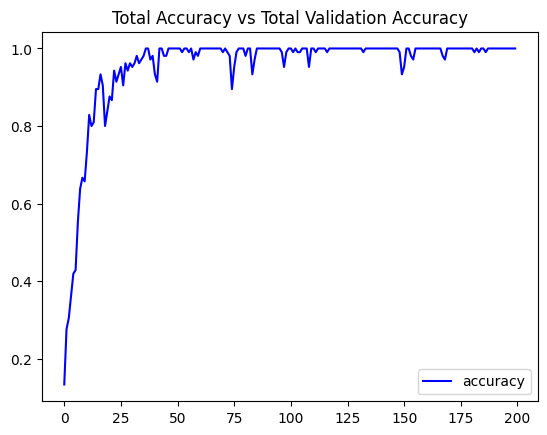

In [49]:
plot_metric(history, 'accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:


model.save('pose.h5')



In [ ]:
from tensorflow import keras
model = keras.models.load_model('pose.h5')


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 64)            50432     
                                                                 
 dropout_3 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 128)           98816     
                                                                 
 dropout_4 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [50]:
predicted_labels_probabilities = model.predict(X_test)
 


1/1 [==============================] - 4s 4s/step


In [51]:
predicted_labels_probabilities

array([[1.71779637e-15, 3.85990915e-14, 1.00000000e+00, 8.87439892e-22,
        6.68108892e-14, 4.62051543e-11],
       [4.34447374e-11, 1.76014134e-10, 1.00000000e+00, 3.17193589e-16,
        1.20640420e-09, 2.09764224e-08],
       [1.00000000e+00, 3.68977923e-19, 6.89910114e-18, 7.01832942e-21,
        4.43161782e-17, 1.05154088e-19],
       [9.45282466e-07, 7.38355506e-04, 3.40647995e-04, 1.68463809e-03,
        2.76386626e-02, 9.69596744e-01],
       [1.06917375e-24, 6.71605065e-20, 6.84611581e-26, 1.00000000e+00,
        4.34352572e-20, 8.71099633e-13],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.44495302e-33, 3.35323085e-27],
       [3.11825704e-10, 8.92432073e-10, 9.99999762e-01, 3.98093119e-14,
        7.74549207e-08, 2.11365119e-07],
       [1.30166250e-13, 1.03246545e-12, 1.00000000e+00, 1.22025555e-19,
        4.71913654e-12, 2.65203998e-10],
       [1.00000000e+00, 2.46484436e-14, 3.49255049e-13, 1.06142895e-15,
        1.21144978e-12, 

In [52]:
Y_pred = np.argmax(predicted_labels_probabilities, axis =1 )

In [53]:
Y_pred

array([2, 2, 0, 5, 3, 1, 2, 2, 0, 3, 4, 5, 2, 3, 5, 0, 1, 1, 3, 3, 0, 2,
       2, 5, 0, 5, 5], dtype=int64)

In [54]:
Y_actual = np.argmax(y_test, axis =1 )

In [55]:
Y_actual

array([2, 2, 0, 5, 3, 1, 2, 2, 0, 3, 4, 5, 2, 3, 5, 0, 1, 1, 3, 3, 0, 2,
       2, 5, 0, 5, 5], dtype=int64)

In [8]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
    
    frames_list = frames_extraction(video_file_path)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    return predicted_class_name
        
    # Release the VideoCapture object. 
    


In [ ]:
datadir="Videodata/testing_video"
classlis=["Bhuj","pad","shav","tad","vrik"]
for class_index, class_name in enumerate(classlis):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(datadir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(f'file name: {file_name}')
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name) 
            predicted_value = predict_single_action(video_file_path, SEQUENCE_LENGTH)
            # Get the complete video path.
            
            
            

In [ ]:
cap = cv2.VideoCapture('output10.mp4')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image,predicted_value, (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import cv2
import time

# Set video codec and frame rate
codec = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30.0

# Open default camera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error opening camera.")
    exit()

# Get camera resolution and set video output size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width, height)

# Create VideoWriter object to save video
filename = "output3.mp4"
out = cv2.VideoWriter(filename, codec, fps, size)

# Record video for specified time
duration = 10.0  # in seconds
start_time = time.time()
while (time.time() - start_time) < duration:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()




In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(X_train, y_train, epochs=100,batch_size=4, callbacks=[tb_callback])